<a href="https://colab.research.google.com/github/debashis-das/cnn_research/blob/main/cnn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d ashwingupta3012/human-faces
!kaggle datasets download -d itsahmad/indoor-scenes-cvpr-2019

100% 1.82G/1.82G [00:19<00:00, 68.1MB/s]
100% 1.82G/1.82G [00:19<00:00, 100MB/s] 
 99% 2.32G/2.34G [00:25<00:00, 136MB/s]
100% 2.34G/2.34G [00:25<00:00, 98.6MB/s]


In [ ]:
!unzip human-faces.zip
!unzip indoor-scenes-cvpr-2019.zip

In [12]:
!mkdir training_checkpoints

In [ ]:
!pip install mitdeeplearning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.3.0-py3-none-any.whl size=2117305 sha256=d5ea0e2176a96a1c1f563b6d4fdc3df140e0390c22e23a39ee5ca9e222a3ca70
  Stored in directory: /root/.cache/pip/wheels/9c/9f/b5/0e31f83bc60a83625e37429f923934e26802d0d68cf3ef3216
Successfully built mitdeeplearning


In [3]:
import random

import h5py
import numpy as np
import os
import cv2 as cv
import tensorflow as tf
import sys
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import functools
import mitdeeplearning as mdl
from tqdm import tqdm

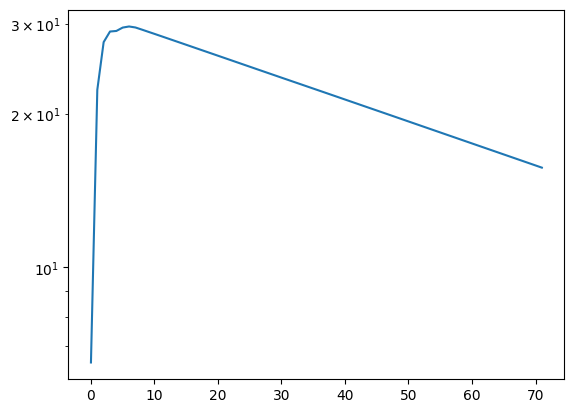

StagingError: ignored

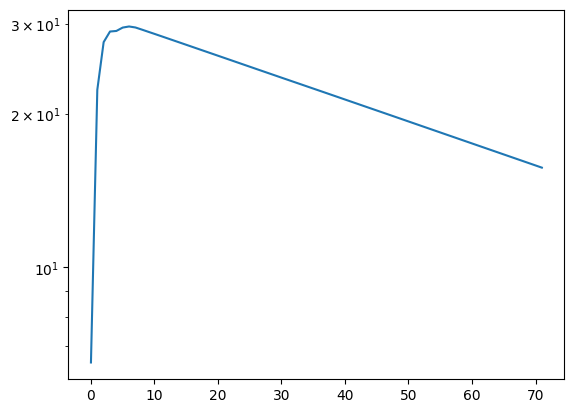

In [24]:
path = './Humans'
humans = []
for filename in os.listdir(path):
    file = os.path.join(path, filename)
    humans.append(file)

path = './indoorCVPR_09/Images'
non_humans = []
for filename in os.listdir(path):
    current_path = os.path.join(path, filename)
    for image_name in os.listdir(current_path):
        file = os.path.join(current_path, image_name)
        non_humans.append(file)
non_human_set = set()
human_set = set()
images_numpy = np.array([])
labels_numpy = np.array([])

def save_model(model):
  checkpoint_path = f'./training_checkpoints/checkpoint.h5'
  # Save the weights
  model.save_weights(checkpoint_path)

def load_model(model):
  checkpoint_path = f'./training_checkpoints/checkpoint.h5'
  # Load the weights
  model.load_weights(checkpoint_path)

n_filters = 32
# Model
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu', input_shape=(640,640,3))
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

### Train the standard CNN ###

# Training hyperparameters
batch_size = 100
total_batches = len(humans)//batch_size
num_epochs = 2  # keep small to run faster
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y, model):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = model(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

standard_classifier = None
# The training loop!
for epoch in range(num_epochs):
  for i in range(total_batches):
    images_temp = []
    labels_temp = []
    # percent of division between positive and negative cases
    humans_counter = int(0.8*batch_size)
    non_humans_counter = int(0.2*batch_size)

    for current_human_path in humans[batch_size*i:]:
        if humans_counter <= 0:
          break
        try:
            images_temp.append(cv.resize(cv.imread(current_human_path), (640, 640)))
            labels_temp.append([1.])
            humans_counter -= 1
            human_set.add(current_human_path)
        except Exception as e:
            print(current_human_path, ' has problem', str(e))
    while non_humans_counter > 0:
        current_non_human_path = non_humans[random.randrange(len(non_humans)) - 1]
        try:
            images_temp.append(cv.resize(cv.imread(current_non_human_path), (640, 640)))
            labels_temp.append([0.])
            non_humans_counter -= 1
            non_human_set.add(current_non_human_path)
        except Exception as e:
            print(current_non_human_path, ' has problem', str(e))
    # print('progress ---> ', 100 * len(human_set) / len(humans))
    images_numpy_temp = np.array(images_temp)
    labels_numpy_temp = np.array(labels_temp)
    # load model
    if i==0:
      standard_classifier = make_standard_classifier()
    else:
      load_model(standard_classifier)
      # print('iteration : ',i,type(standard_classifier))
    # Grab a batch of training data and propagate through the network
    loss = standard_train_step(images_numpy_temp, labels_numpy_temp.astype(np.float32), standard_classifier)
    save_model(standard_classifier)
    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

print('Trained...')
# print(images)


In [ ]:
### Evaluation of standard CNN ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 1s 3ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9982


(100, 64, 64, 3)
(1, 64, 64, 3)
Test Image tf.Tensor([[1759.386]], shape=(1, 1), dtype=float32)
Test Image (Train) tf.Tensor([[12.711713]], shape=(1, 1), dtype=float32)


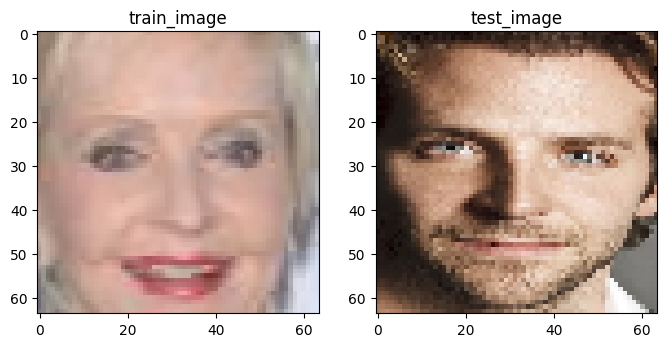

In [ ]:
from google.colab.patches import cv2_imshow
test_img = cv.resize(cv.imread('/content/1.jpg'),(64,64))
test_img = test_img[...,::-1]
(images, labels) = loader.get_batch(100)
face_images = images[np.where(labels==1)[0]]
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
plt.imshow(images[78])
plt.title('train_image')

plt.subplot(1, 2, 2)
plt.imshow(test_img)
plt.title('test_image')
print(images.shape)
print(test_img[np.newaxis,...].shape)
print('Test Image',standard_classifier(test_img[np.newaxis,...]))
new_image = images[78]
print('Test Image (Train)',standard_classifier(new_image[np.newaxis,...]))

1/1 - 0s - loss: 4.0927 - accuracy: 0.4667 - 75ms/epoch - 75ms/step


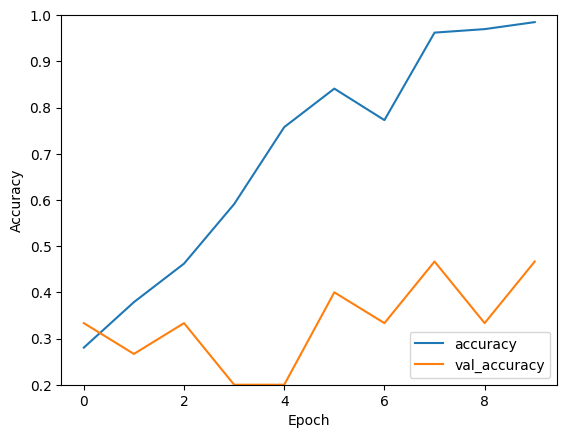

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(images_test_numpy,labels_test_numpy, verbose=2)

In [ ]:
(train_ex_images, train_ex_labels), (test_ex_images, test_ex_labels) = datasets.cifar10.load_data()
print(type(train_ex_images),type(train_ex_images))
print(test_ex_labels)

20 58


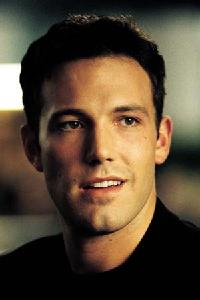

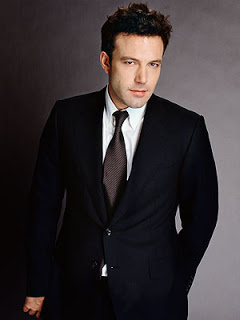

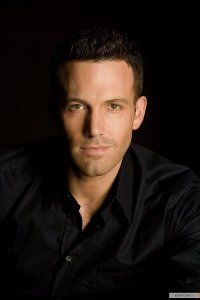

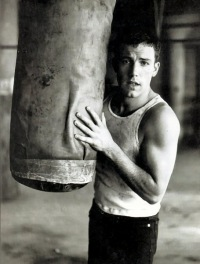

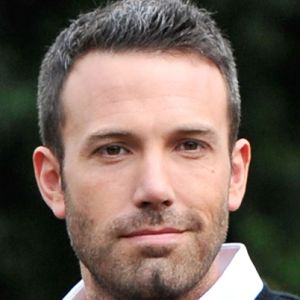

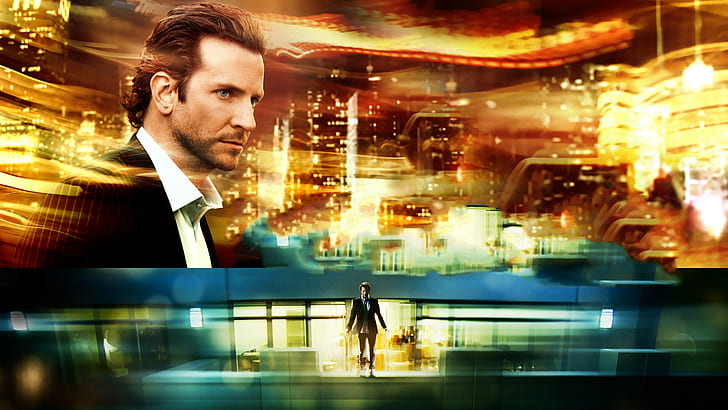

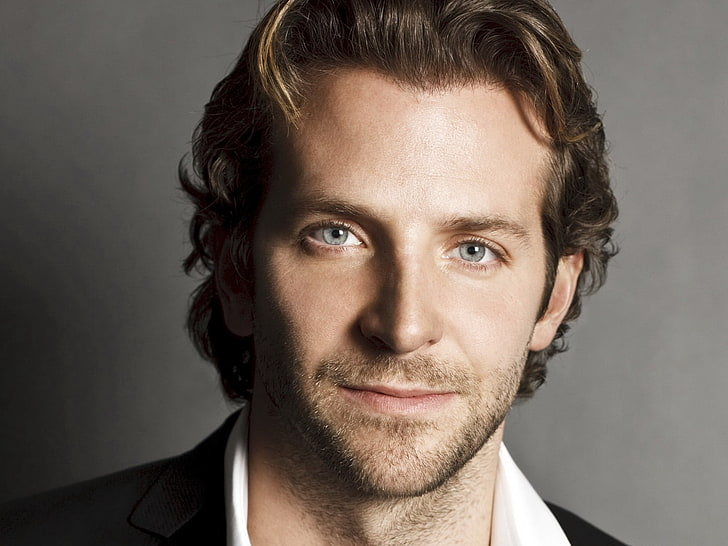

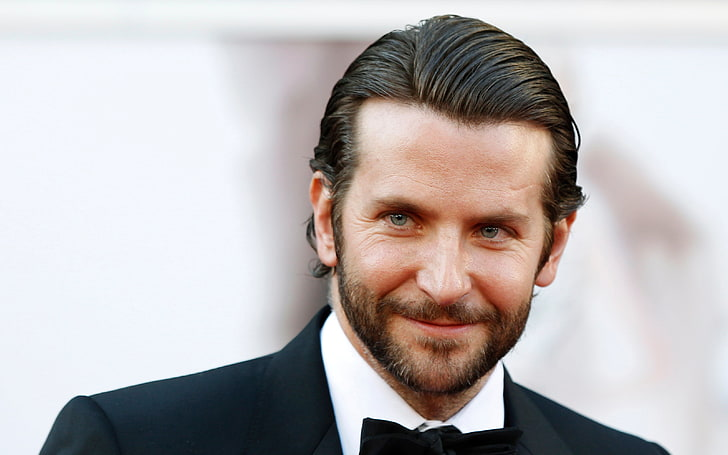

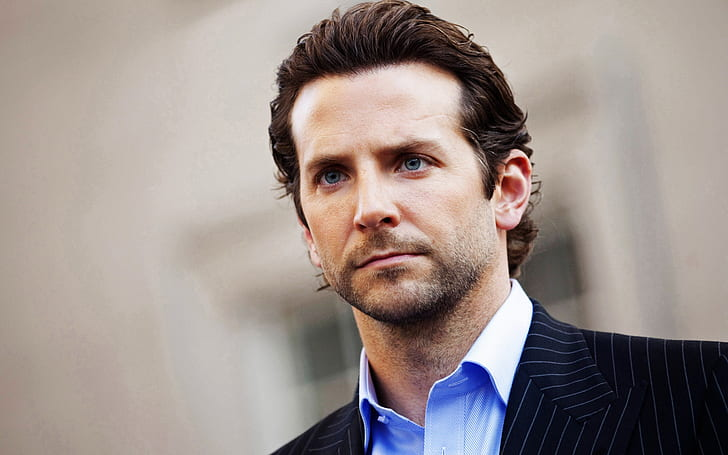

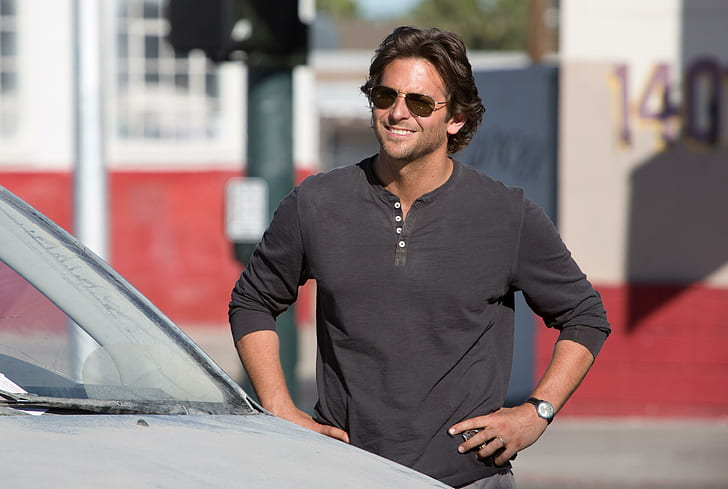

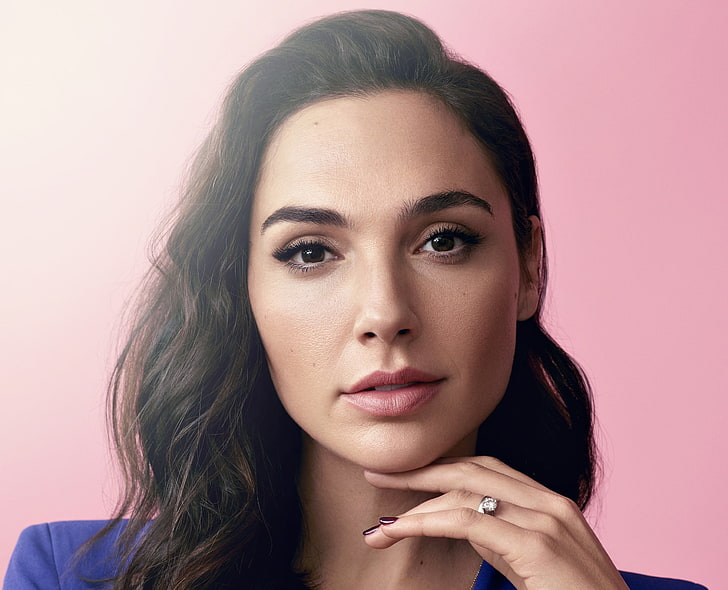

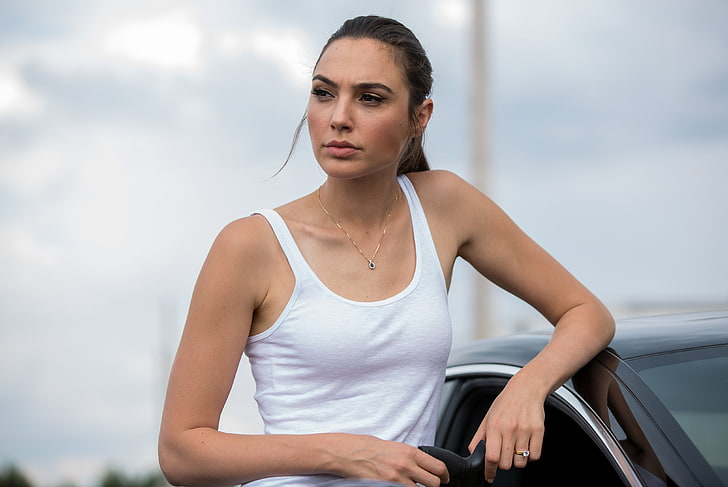

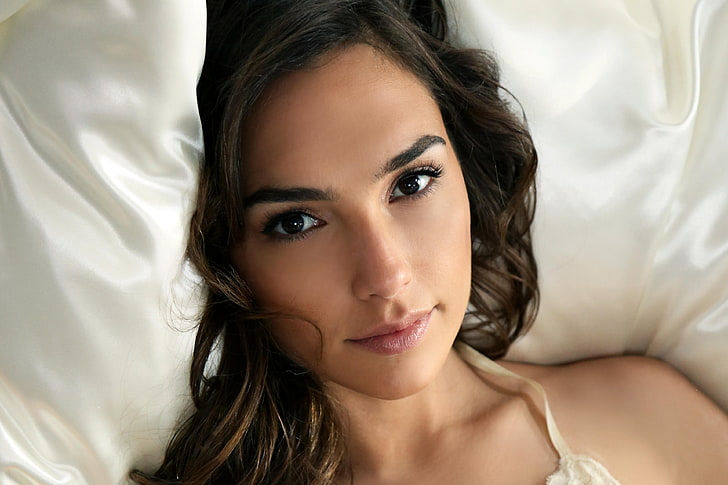

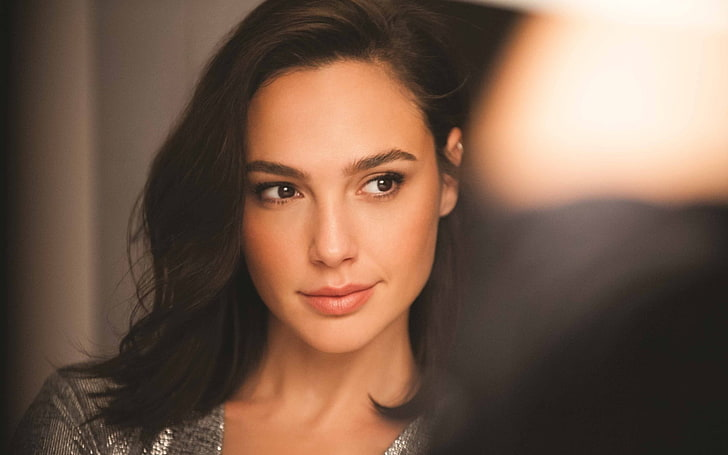

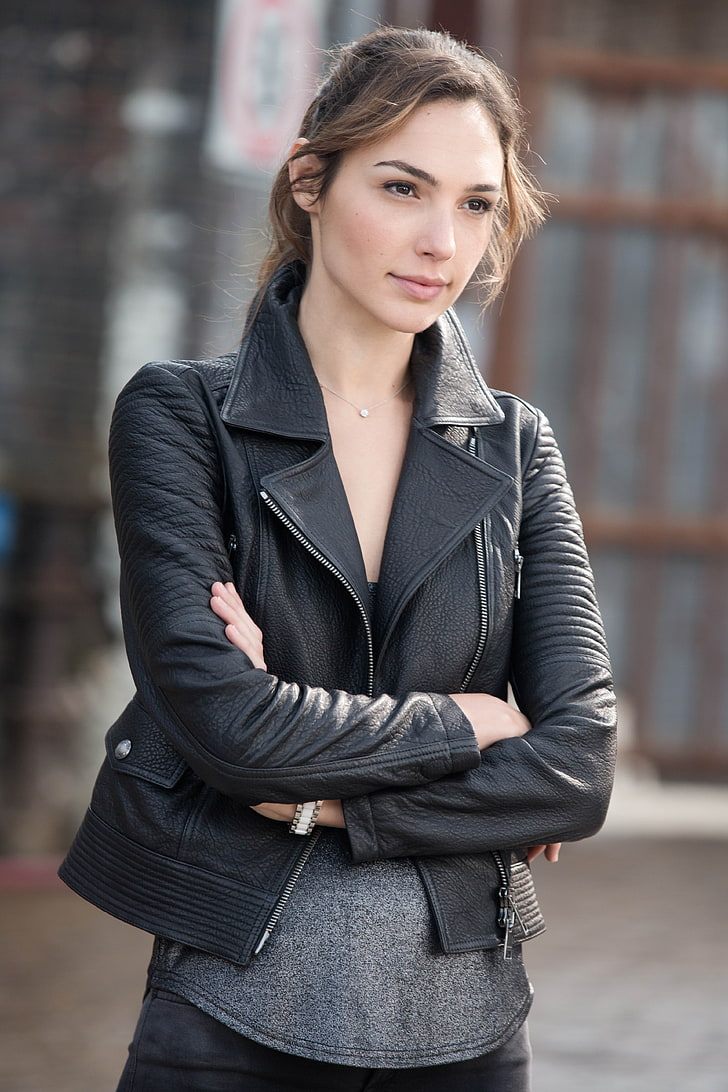

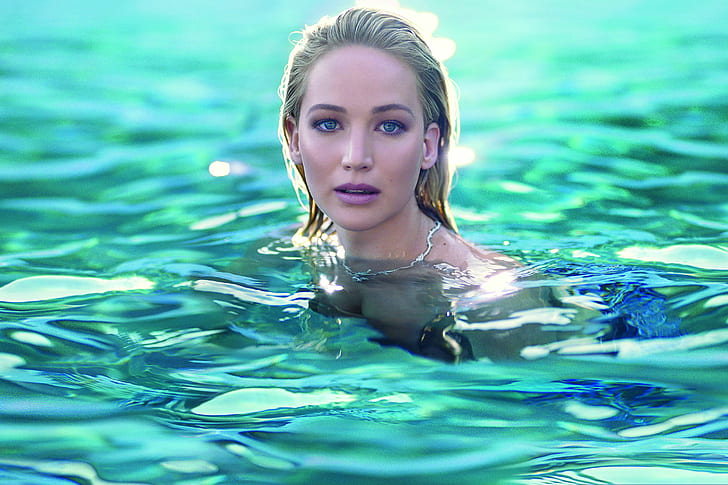

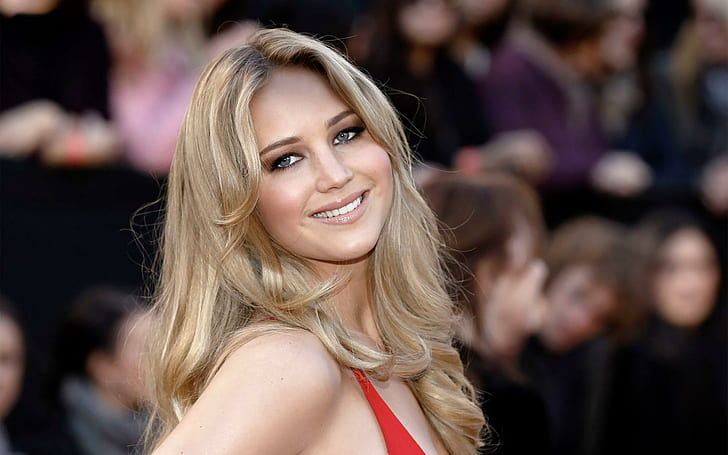

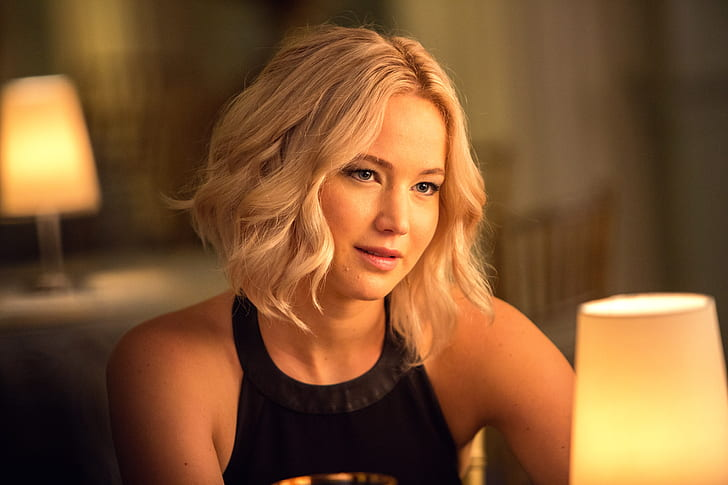

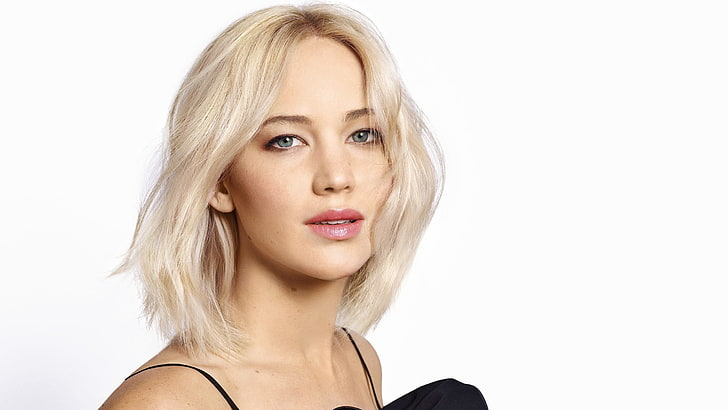

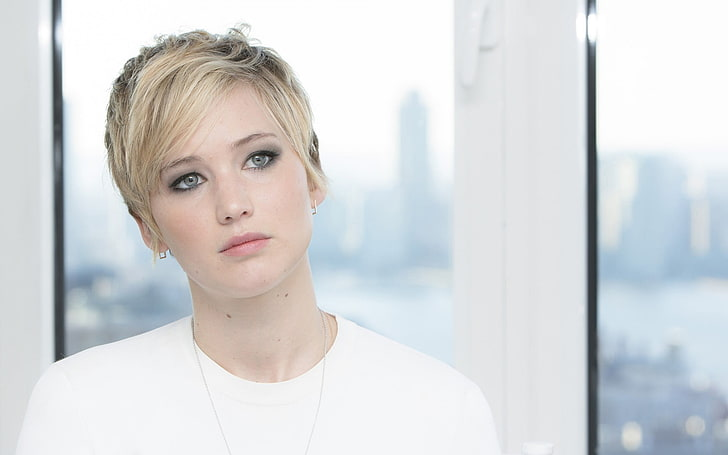

In [ ]:
# from google.colab.patches import cv2_imshow
# print(len(test_images),len(train_images))
# for image in test_images:
#   cv2_imshow(image[0])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

ValueError: ignored

# New Section